## 1. Configuration & Imports

In [1]:
# Standard library
import warnings
warnings.filterwarnings("ignore")

# Third-party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as pe
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import AutoMinorLocator

In [2]:
# =============================================================================
# CONSTANTS & CONFIGURATION
# =============================================================================

# Figure styling
FIGURE_SIZE = (16, 9)
ERRORBAR_WIDTH = 1
ERRORBAR_CAPSIZE = 3
SCATTER_SIZE = 50
LABEL_FONTSIZE = 18
TICK_FONTSIZE = 15

# Temperature axis limits
TEFF_MIN = 5000
TEFF_MAX = 7000

# Physical constants
JUPITER_TO_SOLAR_MASS = 0.0009545942339693249
WASP94_STELLAR_MASS = 1.45  # Solar masses (from Gaia DR3)

# Data quality thresholds
MASS_RATIO_MIN = 0.0003
MASS_RATIO_MAX = 0.002
STELLAR_LOGG_MIN = 3.75
STELLAR_AGE_MIN = 0.2  # Gyr
PLANET_DISTANCE_RATIO_MAX = 10

# Kraft boundary temperatures (K) with uncertainties
# For binary star sample
KB_BINARIES = {"teff": 6105, "lerr": 133, "uerr": 123}
# For single star sample  
KB_SINGLES = {"teff": 6447, "lerr": 119, "uerr": 85}
# From vsini analysis
KB_VSINI = {"teff": 6510, "lerr": 127, "uerr": 97}

# Spectral type color scheme (type, hex color, representative Teff)
SPECTRAL_COLORS = [
    ("M", "#d20000", 3500),
    ("K", "#e65a00", 4800),
    ("G", "#f09600", 5800),
    ("F", "#ffd202", 7000),
    ("A", "#82d2ff", 9000),
]

# Spectral type labels for colorbar
SPECTRAL_LABELS = {
    "M0V": 3850, "K3V": 4830, "G2V": 5770, "F7V": 6280,
    "F5V": 6550, "F2V": 6820, "A6V": 7910, "A2V": 8800
}

## 2. Helper Functions

In [3]:
def setup_axis_style(ax, labelsize=TICK_FONTSIZE, tickwidth=2, ticklength=5):
    """Configure axis tick marks and spines for publication-quality plots."""
    ax.tick_params(
        direction='in', which='both',
        width=tickwidth, length=ticklength, colors='k',
        bottom=True, top=True, left=True, right=True,
        labelsize=labelsize
    )
    for spine in ax.spines.values():
        spine.set_linewidth(tickwidth)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())




def create_temperature_colormap():
    """Create colormap and colorbar image for spectral type visualization."""
    color_list = [c[1] for c in SPECTRAL_COLORS]
    temp_values = np.array([c[2] for c in SPECTRAL_COLORS])
    
    temp_cmap = LinearSegmentedColormap.from_list("tempbar", color_list)
    
    # Normalize to current temperature range
    Tmin, Tmax = temp_values.min(), temp_values.max()
    norm_low = np.clip((TEFF_MIN - Tmin) / (Tmax - Tmin), 0, 1)
    norm_up = np.clip((TEFF_MAX - Tmin) / (Tmax - Tmin), 0, 1)
    
    # Create colorbar image
    bar_img = np.tile(np.linspace(norm_low, norm_up, 500), (40, 1))
    
    return temp_cmap, bar_img

## 3. Data Loading & Filtering

Load the obliquity catalog, apply quality cuts, and separate into single/binary samples.

In [4]:
df = pd.read_csv('obliquity_filtered.csv')
# Split by binary status
df_binaries = df[~df['BinaryMultiStarFlag'].isna()]
df_singles = df[df['BinaryMultiStarFlag'].isna()]

# Load vsini data for comparison
teff_vsini, vsini_values, *_ = np.loadtxt('vsini.csv', delimiter=',', unpack=True)

print(f"Total systems: {len(df)}")
print(f"  Single stars: {len(df_singles)}")
print(f"  Binary/multi: {len(df_binaries)}")

Total systems: 91
  Single stars: 50
  Binary/multi: 41


## 4. Static Visualization

Simple scatter plot showing projected rotation velocity vs. effective temperature.

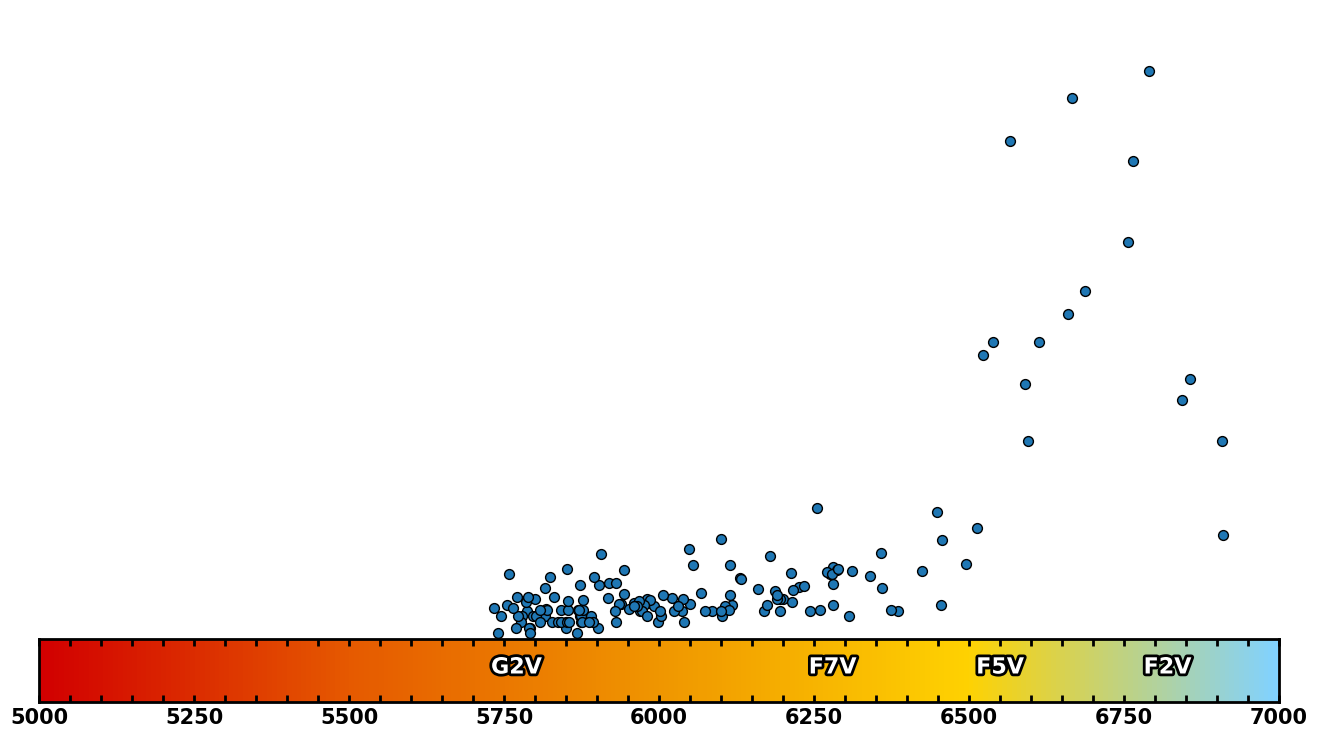

In [5]:
# Create colormap
temp_cmap, bar_img = create_temperature_colormap()

# Set up figure with 2-panel layout
fig = plt.figure(figsize=FIGURE_SIZE)
gs = gridspec.GridSpec(2, 1, height_ratios=(5, 0.5))
plt.subplots_adjust(hspace=0.0)

# --- Top panel: vsini scatter plot ---
ax_scatter = plt.subplot(gs[0])
ax_scatter.scatter(
    teff_vsini, vsini_values, 
    c='C0', s=SCATTER_SIZE, alpha=1, 
    edgecolors='k', label='Single Stars'
)
ax_scatter.set_ylabel('Projected Spin-Orbit Angle (deg)', 
                      fontsize=LABEL_FONTSIZE, fontweight='bold')
ax_scatter.set_xlim(TEFF_MIN, TEFF_MAX)
ax_scatter.set_ylim(0, 110)
ax_scatter.axis('off')

# --- Bottom panel: Spectral type colorbar ---
ax_cbar = plt.subplot(gs[1])
ax_cbar.imshow(bar_img, aspect="auto", cmap=temp_cmap, 
               extent=[TEFF_MIN, TEFF_MAX, 0, 1])
ax_cbar.set_yticks([])

# Add spectral type labels
for label, temp in SPECTRAL_LABELS.items():
    if TEFF_MIN <= temp <= TEFF_MAX:
        ax_cbar.text(
            temp, 0.55, label,
            ha="center", va="center",
            fontsize=16, fontweight="bold", color="white",
            path_effects=[pe.withStroke(linewidth=4, foreground="black")]
        )

setup_axis_style(ax_cbar)
ax_cbar.set_xlim(TEFF_MIN, TEFF_MAX)
ax_cbar.set_xticklabels([f'{int(x)}' for x in ax_cbar.get_xticks()], fontweight='bold')

plt.show()

## 5. Animated Kraft Boundary Shift

Create an animation showing the Kraft Boundary shifting from the binary star value (~6105 K) to the single star value (~6447 K).

Saved: shift_KraftBoundary.mp4


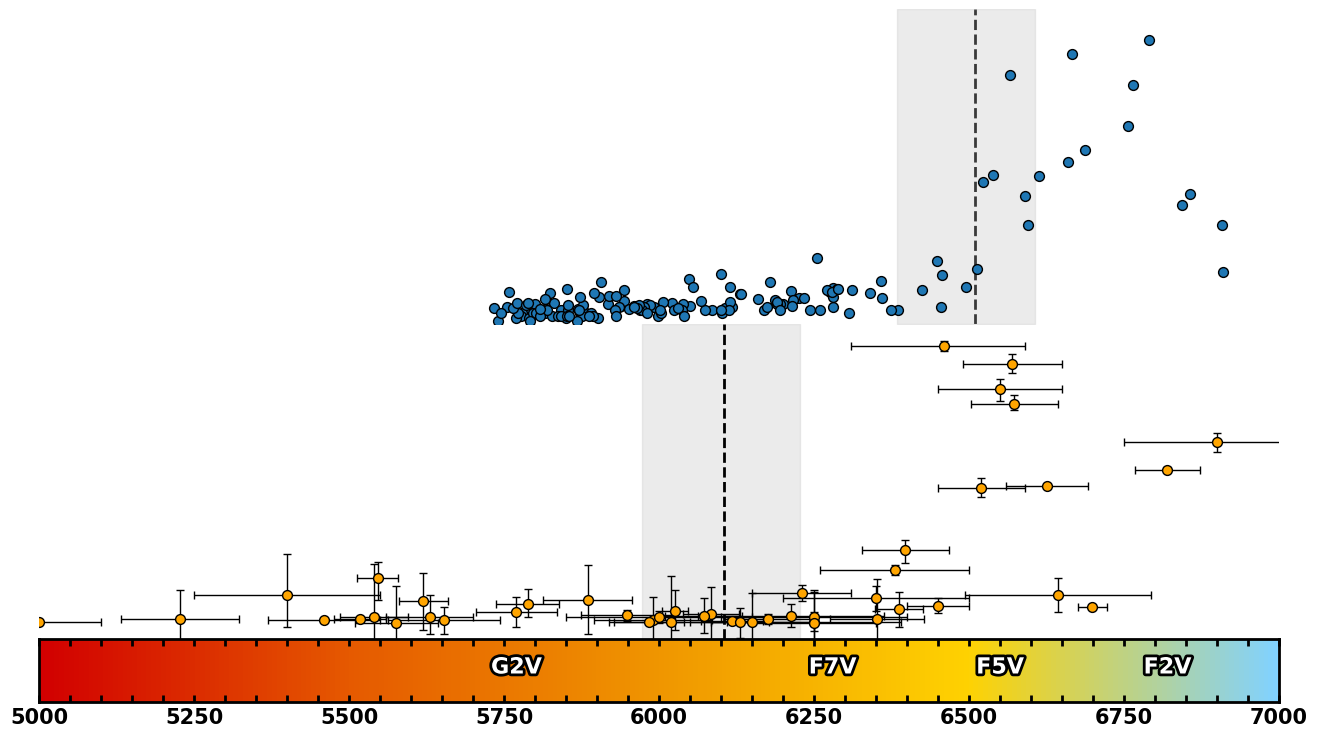

In [6]:
# Extract single star data for plotting
teff_singles = df_singles['teff']
teff_singles_uerr = df_singles['teffuerr']
teff_singles_lerr = df_singles['tefflerr']
lambda_singles = df_singles['normalized_lambdadeg']
lambda_singles_uerr = df_singles['normalized_lambdauerr']
lambda_singles_lerr = df_singles['normalized_lambdalerr']

# Create 3-panel figure
fig = plt.figure(figsize=FIGURE_SIZE)
gs = gridspec.GridSpec(3, 1, height_ratios=(2.5, 2.5, 0.5))
plt.subplots_adjust(hspace=0)

# --- Panel 1: vsini data with Kraft boundary ---
ax_vsini = plt.subplot(gs[0])
ax_vsini.scatter(teff_vsini, vsini_values, s=SCATTER_SIZE, edgecolors='k', color='C0')
ax_vsini.axvline(KB_VSINI["teff"], color='k', linestyle='--', linewidth=2, zorder=-100)
ax_vsini.fill_betweenx(
    [0, 110], 
    KB_VSINI["teff"] - KB_VSINI["lerr"], 
    KB_VSINI["teff"] + KB_VSINI["uerr"],
    color='silver', alpha=0.3, zorder=-100
)
ax_vsini.set_ylim(0, 110)
ax_vsini.set_xlim(TEFF_MIN, TEFF_MAX)
ax_vsini.axis("off")

# --- Panel 2: Obliquity data (animated) ---
ax_obliq = plt.subplot(gs[1])
ax_obliq.errorbar(
    teff_singles, lambda_singles,
    xerr=[teff_singles_lerr, teff_singles_uerr],
    yerr=[lambda_singles_lerr, lambda_singles_uerr],
    fmt='o', color='k', 
    elinewidth=ERRORBAR_WIDTH, capsize=ERRORBAR_CAPSIZE
)
ax_obliq.scatter(teff_singles, lambda_singles, c='orange', s=SCATTER_SIZE, 
                 edgecolors='k', zorder=300)
ax_obliq.set_xlim(TEFF_MIN, TEFF_MAX)
ax_obliq.set_ylim(-10, 190)
ax_obliq.axis("off")

# --- Panel 3: Spectral type colorbar ---
ax_cbar = plt.subplot(gs[2])
ax_cbar.imshow(bar_img, aspect="auto", cmap=temp_cmap,
               extent=[TEFF_MIN, TEFF_MAX, 0, 1])
ax_cbar.set_yticks([])

for label, temp in SPECTRAL_LABELS.items():
    if TEFF_MIN <= temp <= TEFF_MAX:
        ax_cbar.text(
            temp, 0.55, label,
            ha="center", va="center",
            fontsize=16, fontweight="bold", color="white",
            path_effects=[pe.withStroke(linewidth=4, foreground="black")]
        )

setup_axis_style(ax_cbar)
ax_cbar.set_xlim(TEFF_MIN, TEFF_MAX)
ax_cbar.set_xticklabels([f"{int(x)}" for x in ax_cbar.get_xticks()], fontweight="bold")

# --- Animation setup ---
# Initial state: binary Kraft boundary
line = ax_obliq.axvline(KB_BINARIES["teff"], color='k', linestyle='--', linewidth=2, zorder=-50)
shadow = ax_obliq.fill_betweenx(
    [-10, 190], 
    KB_BINARIES["teff"] - KB_BINARIES["lerr"], 
    KB_BINARIES["teff"] + KB_BINARIES["uerr"],
    color='silver', alpha=0.3, zorder=-60
)

# Animation parameters
N_FRAMES = 120
INTERVAL_MS = 30


def smooth_step(t):
    """Smooth interpolation using cubic Hermite (ease in-out)."""
    return t * t * (3 - 2 * t)


def update_frame(frame):
    """Update animation frame: shift Kraft boundary from binary to single value."""
    global shadow
    
    t = smooth_step(frame / (N_FRAMES - 1))
    
    # Interpolate temperature and uncertainties
    teff = KB_BINARIES["teff"] + (KB_SINGLES["teff"] - KB_BINARIES["teff"]) * t
    lerr = KB_BINARIES["lerr"] + (KB_SINGLES["lerr"] - KB_BINARIES["lerr"]) * t
    uerr = KB_BINARIES["uerr"] + (KB_SINGLES["uerr"] - KB_BINARIES["uerr"]) * t
    
    # Update vertical line
    line.set_xdata([teff, teff])
    
    # Update uncertainty shading
    shadow.remove()
    shadow = ax_obliq.fill_betweenx(
        [-10, 190], teff - lerr, teff + uerr,
        color='silver', alpha=0.3, zorder=-60
    )
    
    return line, shadow


# Create and save animation
ani = animation.FuncAnimation(fig, update_frame, frames=N_FRAMES, interval=INTERVAL_MS, blit=False)
ani.save("shift_KraftBoundary.mp4", fps=30, dpi=150)

print("Saved: shift_KraftBoundary.mp4")